# RBF-FD Parallel 

# A function to create a cartesian node distribution



In [1]:
import Base.Threads.@spawn

Threads.nthreads()

8

In [2]:
Threads.threadid()

1

In [3]:

using LinearAlgebra

# Inputs:
#1. bounding_box = 1 X 4 vectors that contains the information about the square domain [Left Right Top Bottom]
#2. Nx = Numbers of nodes along the 'x'- axis
#3. Ny = Numbers of nodes along the 'y'- axis

function node_distribution(bounding_box,Nx,Ny)
    
a=bounding_box[1];
b=bounding_box[2];
c=bounding_box[3];
d=bounding_box[4];


delta_x=(b-a)/(Nx-1); # Mesh size
delta_y=(d-c)/(Ny-1);

# Line space
x1=a:delta_x:b; 
y1=c:delta_y:d;


xd=repeat(transpose(x1),Nx,1);
yd=repeat(y1,1,Ny);

x=xd[:];
y=yd[:];
    
    return x, y
end


node_distribution (generic function with 1 method)

# Domain infromation and the node distribution

In [4]:
# Domain is [0,1] X [0,1] = [a,b] X [c,d]

a=0;
b=1;
c=0;
d=1;

bounding_box=[a b c d];

Nx=20; # Number of nodes on the x axis 
Ny=20; # Number of nodes on the y axis 

x,y =node_distribution(bounding_box,Nx,Ny);


# If you want to plot the node-distribution uncomment lines below
#using Plots
#scatter(x,y,markersize = 0.5,title="RBF-Node Distribution", label ="Nodes",xlabel="x-axis",ylabel="y-axis")

## Let's separate nodes on the boundary and interior nodes

In [5]:
# All nodes on the vertical boundary
delta_om1=findall(k->(k==a ) |(k==b),x);

# All nodes on the horizontal boundary
delta_om2=findall(k->(k==c ) |(k==d),y);

# All the boundary nodes
delta_om=unique([delta_om1;delta_om2]);

# let's count the number of nodes on the boundary
NBC=size(delta_om)[1];

# Nodes on the left vertical boundary
delta_om_left=findall(k-> (k==a),x);

# let's count the number of nodes on the left vertical boundary
Nleft=size(delta_om_left)[1];


# Nodes on the right vertical boundary
delta_om_right=findall(k-> (k==b),x);

# let's count the number of nodes on the right vertical boundary
Nright=size(delta_om_right)[1];

# Nodes on the top horizontal boundary
delta_om_top=findall(k-> (k==d),y);

delta_om_top=setdiff(delta_om_top,delta_om_left);
delta_om_top=setdiff(delta_om_top,delta_om_right);

# let's count the number of nodes on the top horizontal boundary
Ntop=size(delta_om_top)[1];


# Nodes on the bottom horizontal boundary
delta_om_bot=findall(k-> (k==c),y);

delta_om_bot=setdiff(delta_om_bot,delta_om_left);
delta_om_bot=setdiff(delta_om_bot,delta_om_right);

# let's count the number of nodes on the top horizontal boundary
Nbot=size(delta_om_bot)[1];

# Total number of nodes
N=size(x)[1];

# All indexes of the points
index=1:N;

# All interior nodes

index_om=setdiff(index,delta_om);

# Let's count the number of interior nodes

Nin=size(index_om)[1];




## Rearranging nodes - Organizing nodes and categorizing based on the boundary

The rearrangment is made like:
1. Nodes in the interior
2. Nodes on the left vertical boundary
3. Nodes on the right vertical boundary
4. Nodes on the top horizontal boundary
5. Nodes on the bottom horizontal boundary

In [6]:
# New rearranged x nodes

xnew=vcat(x[index_om],x[delta_om_left],x[delta_om_right],x[delta_om_top],x[delta_om_bot]);

# New rearranged y nodes

ynew=vcat(y[index_om],y[delta_om_left],y[delta_om_right],y[delta_om_top],y[delta_om_bot]);

# Let's get the indices

# All interior nodes
index_om=1:Nin;

# Nodes on the left vertical boundary
delta_om_left=Nin+1:Nin+Nleft;

# Nodes on the right vertical boundary
delta_om_right=Nin+Nleft+1:Nin+Nleft+Nright;

# Nodes on the top horizontal boundary
delta_om_top=Nin+Nleft+Nright+1:Nin+Nleft+Nright+Ntop;

# Nodes on the bottom horizontal boundary
delta_om_bot=Nin+Nleft+Nright+Ntop+1:N;

x=xnew;
y=ynew;

#scatter(xnew[index_om],ynew[index_om],markersize = 0.5,title="RBF-Node Distribution", label ="inside",xlabel="x-axis",ylabel="y-axis")
#scatter!(xnew[delta_om_left],ynew[delta_om_left],markersize =0.5,title="RBF-Node Distribution", label ="left")
#scatter!(xnew[delta_om_right],ynew[delta_om_right],markersize = 0.5,title="RBF-Node Distribution", label ="right")
#scatter!(xnew[delta_om_top],ynew[delta_om_top],markersize = 0.5,title="RBF-Node Distribution", label ="top")
#scatter!(xnew[delta_om_bot],ynew[delta_om_bot],markersize = 0.5,title="RBF-Node Distribution", label ="bot")

## RBF-FD Parameters

In [7]:
# Augmented polynomial degree
p=4; 

# RBF Order
m=7;

# Number of neighbors 
n=((p+2)*(p+1))+7;

In [8]:
# Define Radial Basis Functions - We use polyharmonic splines
    
function phi(X1,X2,Y1,Y2,alpha)
    return sqrt.((X1-X2).^2+(Y1-Y2).^2).^alpha
end
    
# Laplacian of phi
function phi_lap(X1,X2,Y1,Y2,alpha)
    return alpha^2 .* sqrt.((X1-X2).^2+(Y1-Y2).^2).^(alpha-2)
end


phi_lap (generic function with 1 method)

## The next function will compute the differentiation weights for the Laplacian in parallel

In [9]:
function weights_lap(xn,yn,m,P,n,ax_exp,ay_exp,x_exp,y_exp,x_exp_Dx,y_exp_Dy,x_exp_Dxx,y_exp_Dyy)
    
#xn=transpose(xn);
#yn=transpose(yn);

  
xn_temp=repeat(xn,1,P);
yn_temp=repeat(yn,1,P);
    
X1=repeat(transpose(xn),n,1);
X2=repeat(xn,1,n);
    
Y1=repeat(transpose(yn),n,1);
Y2=repeat(yn,1,n);
    
A11=phi(X1,X2,Y1,Y2,m);
   
A12=(xn_temp.^ax_exp).*(yn_temp.^ay_exp);
    
Blap11=phi_lap(X1,X2,Y1,Y2,m)[1,:];
   
Blap12=x_exp.*x_exp_Dx.*(transpose(xn_temp[1,:]).^x_exp_Dxx).*(transpose(yn_temp[1,:]).^y_exp)+y_exp.*y_exp_Dy.*(transpose(xn_temp[1,:]).^x_exp).*(transpose(yn_temp[1,:]).^y_exp_Dyy);

 
# Local collocation matrix
A=[[A11 A12];[transpose(A12) zeros(P,P)]];
    
Blap=[Blap11' Blap12];
   
Dlap_local=Blap/A;#*inv(A) ;

    
    return Dlap_local[1:n]
end

        

weights_lap (generic function with 1 method)

## Setup the differentiation matrices

In [10]:
using NearestNeighbors
using SparseArrays

function Main_weights(x,y,p,m,n)
    
dsites=[x y]; # 2D nodes
    
# Number of terms in the augmented polynomial
P=(p+2)*(p+1)/2;
P=convert(Int64, round(P, digits=0));

# Total number of nodes
N=size(x)[1];

# Find the nearest neighbors

kdtree = KDTree(transpose(dsites));
idx, dist = knn(kdtree, transpose(dsites), n, true);
    
dist=transpose(hcat(dist...)); 
idx=transpose(hcat(idx...)); 
    
# Create the polynomial exponents

x_exp=[];
y_exp=[];

for i=0:p
    x_exp=append!(x_exp, 0:1:i);
    y_exp=append!(y_exp, i.-(0:1:i));
end

x_exp=transpose(x_exp);
y_exp=transpose(y_exp);
# Derivatives of the exponents

x_exp_Dx=x_exp .-1;
x_exp_Dx[x_exp_Dx .<0].=0;
x_exp_Dxx=x_exp .-2;
x_exp_Dxx[x_exp_Dxx .<0].=0;

ax_exp=repeat(x_exp,n,1);
ay_exp=repeat(y_exp,n,1);

y_exp_Dy=y_exp .-1;
y_exp_Dy[y_exp_Dy .<0].=0;
y_exp_Dyy=y_exp .-2;
y_exp_Dyy[y_exp_Dyy .<0].=0; 

# Initialize the differentiation matrices

Z=repeat(dist[:,n],1,n);
Xn=(x[idx]-repeat(x[idx[:,1]],1,n))./Z; # Rescale all nodes to the center
Yn=(y[idx]-repeat(y[idx[:,1]],1,n))./Z; # Rescale all nodes to the center 

Dtemp=zeros(n,N); # Matrix to save Laplacian weights
I=transpose(repeat(1:1:N,1,n)); # All the indexes 1:N
I=I[:];
    
J=transpose(idx); #All the neigbours
J=J[:]; 
    
Threads.@threads for index in 1:N
        Dtemp[:,index]=weights_lap(Xn[index,:],Yn[index,:],m,P,n,ax_exp,ay_exp,x_exp,y_exp,x_exp_Dx,y_exp_Dy,x_exp_Dxx,y_exp_Dyy);
        
    end
    
Dtemp=Dtemp./transpose(Z.^2); 
    
Dlap=sparse(I,J,Dtemp[:]);  
    
return Dlap 
    end    
    
    
    

Main_weights (generic function with 1 method)

In [11]:
@time Dlap=Main_weights(x,y,p,m,n);


  4.047991 seconds (21.09 M allocations: 1.071 GiB, 6.28% gc time)


## True solution & source term

In [12]:
mu=1;
function u(x,y,t)
    return (y.^3 .-1).*(x.^2 .-1).*exp(-mu*t) # The true solution
end

function f(x,y,t)
    return -mu*exp(-mu*t).*(-1 .- 6*y.+ y.^3 .+ x.^2 .* (-1 .+ 6*y .+ y.^3)) # The source term
end


f (generic function with 1 method)

In [13]:
NN=100; # Number of steps
T=0.2; # Final time
dt=T/NN; # Time step


In [14]:
# Differentiation matrix
D1=sparse(I,N,N)-dt*mu*Dlap;



In [15]:
D=[D1[index_om,:];zeros(Nleft,Nin) Matrix{Float64}(I, Nleft, Nleft) zeros(Nleft,Nright+Ntop+Nbot);zeros(Nright,Nin+Nleft) Matrix{Float64}(I, Nright, Nright) zeros(Nright,Ntop+Nbot);zeros(Ntop,Nin+Nleft+Nright) Matrix{Float64}(I, Ntop, Ntop) zeros(Ntop,Nbot);zeros(Nbot,Nin+Nleft+Nright+Ntop) Matrix{Float64}(I, Nbot, Nbot)];

In [16]:
U=zeros(N,NN+1);
U[:,1]=u(x,y,0);

In [17]:
for i in 2:NN+1
    F=dt*f(x,y,(i-1)*dt);
    rhs_temp=U[:,i-1]+F;
    rhs_temp[[delta_om_left;delta_om_right;delta_om_top;delta_om_bot],1]=u(x[[delta_om_left;delta_om_right;delta_om_top;delta_om_bot]],y[[delta_om_left;delta_om_right;delta_om_top;delta_om_bot]],(i-1)*dt);
    U[:,i]=D\rhs_temp;
    
end

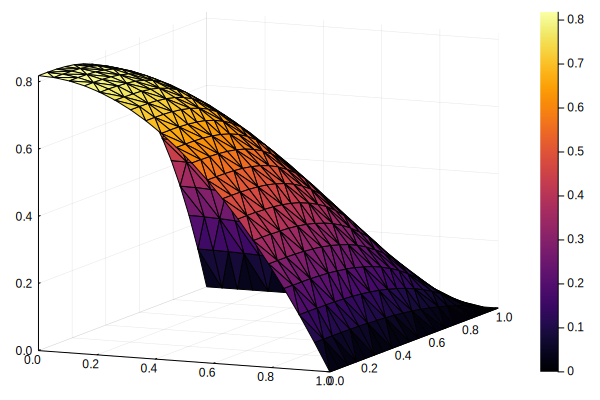

In [18]:
using Plots
plot(x,y,U[:,NN+1],st=:surface)

In [19]:
print(maximum(abs.(U[:,NN+1]-u(x,y,T))))

3.809162263090915e-5